In [10]:
import os, warnings
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import gridspec
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells

# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    './car_or_truck_data/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    './car_or_truck_data/valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


2023-02-19 15:17:02.477701: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-19 15:17:02.484502: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-02-19 15:17:02.484522: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-02-19 15:17:02.484839: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neur

In [11]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    # Block One
    layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same',
                  input_shape=[128, 128, 3]),
    layers.MaxPool2D(),

    # Block Two
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Three
    # YOUR CODE HERE
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Head
    layers.Flatten(),
    layers.Dense(6, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid'),
])

In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

In [13]:
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=50,
)

Epoch 1/50
80/80 [==============================] - 57s 708ms/step - loss: 0.6772 - binary_accuracy: 0.5722 - val_loss: 0.6623 - val_binary_accuracy: 0.5785
Epoch 2/50
80/80 [==============================] - 56s 702ms/step - loss: 0.6613 - binary_accuracy: 0.5787 - val_loss: 0.6463 - val_binary_accuracy: 0.5785
Epoch 3/50
80/80 [==============================] - 56s 703ms/step - loss: 0.6497 - binary_accuracy: 0.5787 - val_loss: 0.6353 - val_binary_accuracy: 0.5785
Epoch 4/50
80/80 [==============================] - 57s 717ms/step - loss: 0.6408 - binary_accuracy: 0.5787 - val_loss: 0.6288 - val_binary_accuracy: 0.5785
Epoch 5/50
80/80 [==============================] - 57s 716ms/step - loss: 0.6333 - binary_accuracy: 0.6037 - val_loss: 0.6203 - val_binary_accuracy: 0.6452
Epoch 6/50
80/80 [==============================] - 57s 712ms/step - loss: 0.6294 - binary_accuracy: 0.6248 - val_loss: 0.6117 - val_binary_accuracy: 0.6628
Epoch 7/50
80/80 [==============================] - 56s 70

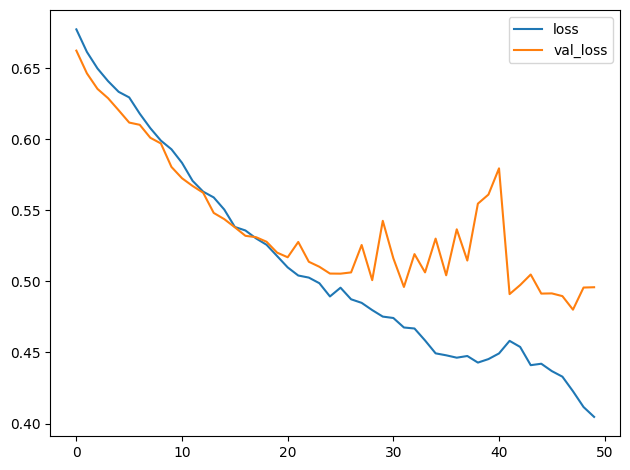

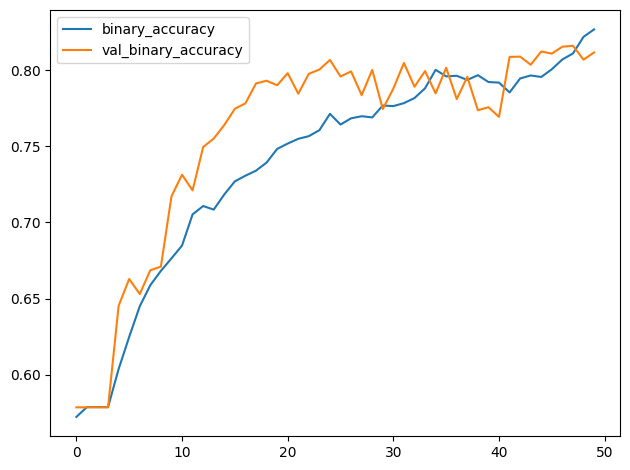

In [15]:
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();